<a href="https://colab.research.google.com/github/dranzer120/ADS-tm-group-comp/blob/main/Assignment_3_1_Group_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS 509 Module 3: Group Comparison

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
* Calculate descriptive statistics on the two sets of lyrics and compare the results.
* For each of the four corpora, find the words that are unique to that corpus.
* Build word clouds for all four corpora.

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [5]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [28]:
# Use this space for any additional import statements you need
#!pip install emoji
import nltk
nltk.download('stopwords')
from collections import Counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Place any addtional functions or constants you need here.

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA :
    for em in emoji.EMOJI_DATA[country] :
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    if not tokens:
        if verbose:
            print("Token list is empty.")
        return [0, 0, 0.0, 0]

    num_total = len(tokens)
    num_unique = len(set(tokens))
    num_chars = sum(len(t) for t in tokens)
    lexical_div = num_unique / num_total if num_total else 0.0

    if verbose:
        print(f"There are {num_total} tokens in the data.")
        print(f"There are {num_unique} unique tokens in the data.")
        print(f"There are {num_chars} characters in the data.")
        print(f"The lexical diversity is {lexical_div:.3f} in the data.")
        print(f"\nTop {num_tokens} most common tokens:")
        for token, count in Counter(tokens).most_common(num_tokens):
            print(f"{token}: {count}")

    return [num_total, num_unique, lexical_div, num_chars]


def contains_emoji(s):

    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return [t for t in tokens if t.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    # modify this function to return tokens
    return whitespace_pattern.split(text.strip())

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)

def remove_titles(text):
    # Remove quoted titles or ALL CAPS lines
    text = re.sub(r'^".*?"', '', text, flags=re.MULTILINE)
    text = re.sub(r'^[A-Z\s\[\]0-9]+$', '', text, flags=re.MULTILINE)
    return text


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "" # change to your location if it is not in the same directory as your notebook
twitter_folder = "/content/drive/MyDrive/Colab Notebooks/twitter/"
lyrics_folder = "/content/drive/MyDrive/Colab Notebooks/lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [15]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [16]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])

del(twitter_data_2)

In [19]:
# read in the lyrics here
lyrics_data = defaultdict(dict)

for filename in os.listdir(lyrics_folder):
    if filename.endswith(".txt"):
        # Split at the first underscore to separate artist and song
        parts = filename.split("_", 1)
        if len(parts) == 2:
            artist, song_file = parts
            file_path = os.path.join(lyrics_folder, filename)
            with open(file_path, "r", encoding="utf-8") as f:
                lyrics_data[artist][song_file] = f.read()

In [34]:
# Flatten nested dictionary into a list of dicts
records = []

for artist, songs in lyrics_data.items():
    for song_filename, lyrics in songs.items():
        records.append({
            "artist": artist,
            "song": song_filename.replace(".txt", ""),
            "lyrics": lyrics
        })

df_lyrics = pd.DataFrame(records)

print(df_lyrics.head())

  artist                      song  \
0   cher                 88degrees   
1   cher                  afterall   
2   cher  adifferentkindoflovesong   
3   cher                     again   
4   cher                     alfie   

                                              lyrics  
0  "88 Degrees"\n\n\n\nStuck in L.A., ain't got n...  
1  "After All"\n\n\n\nWell, here we are again\nI ...  
2  "A Different Kind Of Love Song"\n\n\n\nWhat if...  
3  "Again"\n\n\n\nAgain evening finds me at your ...  
4  "Alfie"\n\n\n\nWhat's it all about, Alfie?\nIs...  


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning.

**Lyrics**

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions**

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.

In [24]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

df_lyrics["tokens"] = df_lyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
df_lyrics["num_tokens"] = df_lyrics["tokens"].map(len)

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)


In [25]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [26]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
2649059,cher,"Hello,I love you ♥ Not really...HAHA xoxo ☺","[helloi, love, ♥, reallyhaha, xoxo, ☺]"
3905758,cher,Temporarily Insane ☺ • @MacdonaldYika Bestie,"[temporarily, insane, ☺, •, macdonaldyika, bes..."
1295646,cher,Não há sinal de vida inteligente 👽🖕🏻,"[não, há, sinal, de, vida, inteligente, 👽🖕🏻]"
1675601,cher,Love my rescue dog Stormy. Coffee and 90’s mus...,"[love, rescue, dog, stormy, coffee, 90’s, musi..."
1499131,cher,Wife/Mother and basketball 🏀 grandma This girl...,"[wifemother, basketball, 🏀, grandma, girl, fol..."
1346267,cher,#My_Leben# 😘,"[#myleben#, 😘]"
944304,cher,"have a big heart love to get people to laugh, ...","[big, heart, love, get, people, laugh, love, a..."
918851,cher,"Danish-Cypriot artist, singer & songwriter. 🌸🌸🌸","[danishcypriot, artist, singer, songwriter, 🌸🌸🌸]"
269643,cher,🦚 Animal Lover 🦙 👻 Sensitive / Empath 💓 🎮 Gamer 🕹,"[🦚, animal, lover, 🦙, 👻, sensitive, empath, 💓,..."
2270648,cher,@m.art.a on instagram • painting fanart with w...,"[marta, instagram, •, painting, fanart, waterc..."


With the data processed, we can now start work on the assignment questions.

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Although we have removed all-caps lines and quotes, but for the lyrics files, it still have markups like [Chorus] and [Verse]. Could have implement functions to remove those as well.

## Calculate descriptive statistics on the two sets of lyrics and compare the results.


In [33]:

# Filter token lists by artist
cher_tokens = df_lyrics[df_lyrics["artist"] == "cher"]["tokens"].explode().tolist()
robyn_tokens = df_lyrics[df_lyrics["artist"] == "robyn"]["tokens"].explode().tolist()

print("=== Cher Lyrics Statistics ===")
cher_stats = descriptive_stats(cher_tokens, num_tokens=10)

print("\n=== Robyn Lyrics Statistics ===")
robyn_stats = descriptive_stats(robyn_tokens, num_tokens=10)


=== Cher Lyrics Statistics ===
There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.103 in the data.

Top 10 most common tokens:
love: 1004
im: 513
know: 486
dont: 440
youre: 333
time: 319
baby: 319
see: 308
oh: 306
one: 282

=== Robyn Lyrics Statistics ===
There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.142 in the data.

Top 10 most common tokens:
know: 308
dont: 301
im: 299
love: 275
got: 251
like: 232
baby: 222
youre: 169
never: 155
dance: 150


Q: what observations do you make about these data?

A: Base on total tokens, Cher has more lyrics overall. Base on Lexical diversity, Robyn's lyrics are more varied.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [32]:
# your code here

cher_tokens = df_lyrics[df_lyrics["artist"] == "cher"]["tokens"].explode().tolist()
robyn_tokens = df_lyrics[df_lyrics["artist"] == "robyn"]["tokens"].explode().tolist()


cher_counts = Counter(cher_tokens)
robyn_counts = Counter(robyn_tokens)

cher_total = len(cher_tokens)
robyn_total = len(robyn_tokens)


cutoff = 5
shared_tokens = set(cher_counts.keys()) & set(robyn_counts.keys())
eligible_tokens = [t for t in shared_tokens if cher_counts[t] >= cutoff and robyn_counts[t] >= cutoff]

# Calculate concentration ratios
ratios_cher = []
ratios_robyn = []

for token in eligible_tokens:
    cher_conc = cher_counts[token] / cher_total
    robyn_conc = robyn_counts[token] / robyn_total

    if robyn_conc > 0:
        ratio_c = cher_conc / robyn_conc
        ratios_cher.append((token, ratio_c))

    if cher_conc > 0:
        ratio_r = robyn_conc / cher_conc
        ratios_robyn.append((token, ratio_r))


top_cher_tokens = sorted(ratios_cher, key=lambda x: x[1], reverse=True)[:10]
top_robyn_tokens = sorted(ratios_robyn, key=lambda x: x[1], reverse=True)[:10]


print("Top 10 Tokens Uniquely Concentrated in Cher Lyrics:")
for token, ratio in top_cher_tokens:
    print(f"{token}: ratio {ratio:.2f}")

print("\nTop 10 Tokens Uniquely Concentrated in Robyn Lyrics:")
for token, ratio in top_robyn_tokens:
    print(f"{token}: ratio {ratio:.2f}")

Top 10 Tokens Uniquely Concentrated in Cher Lyrics:
walk: ratio 10.01
find: ratio 9.68
enough: ratio 7.81
man: ratio 7.53
without: ratio 7.46
strong: ratio 6.53
live: ratio 5.77
believe: ratio 5.59
tears: ratio 4.83
name: ratio 4.41

Top 10 Tokens Uniquely Concentrated in Robyn Lyrics:
beat: ratio 20.26
dance: ratio 14.15
work: ratio 11.95
hang: ratio 11.20
forgive: ratio 7.55
shake: ratio 7.08
alright: ratio 7.08
party: ratio 6.19
space: ratio 5.90
pretend: ratio 5.90


Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A: One thing that stands out is how Cher’s top words like "walk," "tears," and "strong" really lean into themes of heartbreak and personal strength — classic vibes for emotional pop ballads. Her lyrics feel more traditional and story-driven.

## Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.


In [30]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

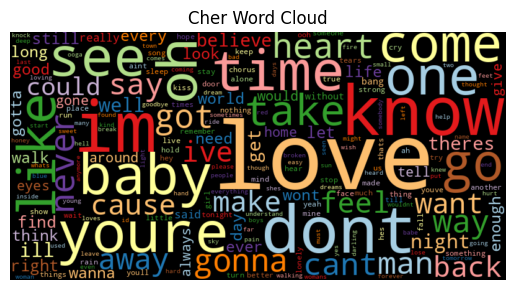

In [31]:
# Count words for Cher
cher_df = df_lyrics[df_lyrics["artist"] == "cher"]
cher_freq = count_words(cher_df, column='tokens', min_freq=5)

# Plot word cloud
wordcloud(cher_freq['freq'], title="Cher Word Cloud", stopwords=set(sw))

Q: What observations do you have about these (relatively straightforward) wordclouds?

A: These wordcloud can very easily emphasize the top tokens within the lyrics.